In [1]:
#기본 import
from datasets import load_dataset, Dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
import transformers
import re
import pandas as pd
import os
import json
import datasets

/usr/anaconda3/envs/triper/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#gpu 확인
!nvidia-smi

Wed Nov  6 16:42:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:2A:00.0 Off |                  Off |
| N/A   62C    P8             17W /   72W |      22MiB /  24570MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
#파이썬 버전 확인
!python -V

Python 3.12.7


In [4]:
import torch
torch.cuda.empty_cache()

In [6]:
#base model 불러오기 - beomi/KoAlpaca-KoRWKV-6B

# tokenizer = AutoTokenizer.from_pretrained("beomi/KoAlpaca-KoRWKV-6B", trust_remote_code=True)
# model = AutoModelForCausalLM.from_pretrained("beomi/KoAlpaca-KoRWKV-6B", device_map={"":'cuda'})

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it", device_map="auto")

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


In [7]:
print("모델 다운로드 완료")

모델 다운로드 완료


In [8]:
#파일 확인
file_list = os.listdir("./data")
print ("file_list: {}".format(file_list))

file_list: ['out_2_hot.csv', 'out_2_food.csv', 'out_2_sleep.csv', 'out_2_play.csv', 'out_2_cafe.csv']


In [9]:
def data_prep_cafe_food(num,category):

    #인덱스 별 지역
    regions = ["종로구", "중구", "용산구", "성동구", "광진구", "동대문구", "중랑구", "성북구", "강북구", "도봉구", "노원구", "은평구", "서대문구", "마포구", "양천구", "강서구", "구로구",
               "금천구", "영등포구", "동작구", "관악구", "서초구", "강남구", "송파구", "강동구"]
    
    #데이터 프레임 컬럼명
    column_headers = ["가게 이름","종류", "주소", "대표메뉴", "대표 메뉴 설명", "후기1", "후기2", "후기3", "후기4", "후기5"]

    #지역 넘버
    k = num

    #입력 데이터 파일 이름
    text = "./data/out_" + str(k) + "_" + category + ".csv"

    #데이터 프레임 가져오기
    tmp_df = pd.read_csv(text, names = column_headers)

    #삭제할 인덱스 저장 리스트
    drop_list = []

    #삭제할 인덱스 찾기
    for i in range(len(tmp_df)):
        if tmp_df.iloc[i, 0] == '-':
            drop_list.append(i)

    #빈 인덱스 삭제
    tmp_df.drop(drop_list, axis = 0, inplace = True)

    #인덱스 재정렬
    tmp_df.reset_index(drop = True, inplace = True)

    #instruction 정의
    prompt = """너는 서울에 대해 잘 알고 있는 여행 작가야. 
    서울에 대해 잘 알고 있어서 사용자가 추천을 해달라고 하면 적절한 추천을 할 수 있어. 단, 서울이 아닌 다른 지역의 장소는 추천하면 안 돼.
    서울의 행정구역 별로 알고 있고, 추천할 수 있는 주제는 ["맛집", "카페", "핫플", "숙소", "놀거리"]야. 
    예를 들어, 용산동 장소를 추천해달라고 하면, 용산동의 맛집 1개, 카페 1개, 핫플 1개, 숙소 1개, 놀거리 1개를 필수로 추천해줘.
    만약 한 주제만 추천해달라고 하면 하나의 주제에 대해 5개 추천해줘. 그리고 각각의 장소는 주소와 영업정보를 꼭 알려줘야 해.
    """

    #저장할 리스트
    ins = [] 

    #데이터 프레임 개수 * 6 = 입력 데이터 개수(종류, 후기1, 후기2, 후기3, 후기4, 후기5)
    ins = [prompt] * len(tmp_df) * 6

    #input data 구성
    input = []
    
    #종류로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 " + tmp_df.iloc[i, 1] + " 추천해줘"
        input.append(input_text)
    
    #리뷰1로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -5] + "'라고 한 가게 추천해줘"
        input.append(input_text)
    
    #리뷰2로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -4] + "'라고 한 가게 추천해줘"
        input.append(input_text)
    
    #리뷰3으로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -3] + "'라고 한 가게 추천해줘"
        input.append(input_text)
    
    #리뷰4로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -2] + "'라고 한 가게 추천해줘"
        input.append(input_text)
    
    #리뷰5로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -1] + "'라고 한 가게 추천해줘"
        input.append(input_text)

    #output data 구성
    output = []

    #output 데이터 구성
    for i in range(6):
        for k in range(len(tmp_df)):
    
            #대표 메뉴
            if str(tmp_df.iloc[k, 3]) == "nan":
                food_name = "정보가 없습니다."
            else:
                food_name = str(tmp_df.iloc[k, 3])
    
            #대표 메뉴 설명 
            if str(tmp_df.iloc[k, 4]) == "nan":
                food_text = "정보가 없습니다."
            else:
                food_text = str(tmp_df.iloc[k, 4])
    
            #매칭
            output_text = "추천 가게는 " + str(tmp_df.iloc[k, 0]) + "입니다." + "주소는 " + str(tmp_df.iloc[k, 2]) + "입니다." + "다음은 가게의 대표 메뉴와 설명입니다.\n" + "대표 메뉴 : " + food_name + " 메뉴 설명 : " + food_text
            output.append(output_text)

    #최종 데이터
    new_data = pd.DataFrame({'instruction':ins, 'user':input, 'answer':output})
    return new_data

In [10]:
def data_prep_hot_play(num,category):

    #인덱스 별 지역
    regions = ["종로구", "중구", "용산구", "성동구", "광진구", "동대문구", "중랑구", "성북구", "강북구", "도봉구", "노원구", "은평구", "서대문구", "마포구", "양천구", "강서구", "구로구",
               "금천구", "영등포구", "동작구", "관악구", "서초구", "강남구", "송파구", "강동구"]
    
    #데이터 프레임 컬럼명
    column_headers = ["가게 이름","종류", "주소", "후기1", "후기2", "후기3", "후기4", "후기5"]

    #지역 넘버
    k = num

    #입력 데이터 파일 이름
    text = "./data/out_" + str(k) + "_" + category + ".csv"

    #데이터 프레임 가져오기
    tmp_df = pd.read_csv(text, names = column_headers)

    #삭제할 인덱스 저장 리스트
    drop_list = []

    #삭제할 인덱스 찾기
    for i in range(len(tmp_df)):
        if tmp_df.iloc[i, 0] == '-':
            drop_list.append(i)

    #빈 인덱스 삭제
    tmp_df.drop(drop_list, axis = 0, inplace = True)

    #인덱스 재정렬
    tmp_df.reset_index(drop = True, inplace = True)

    #instruction 정의
    prompt = """너는 서울에 대해 잘 알고 있는 여행 작가야. 
    서울에 대해 잘 알고 있어서 사용자가 추천을 해달라고 하면 적절한 추천을 할 수 있어. 단, 서울이 아닌 다른 지역의 장소는 추천하면 안 돼.
    서울의 행정구역 별로 알고 있고, 추천할 수 있는 주제는 ["맛집", "카페", "핫플", "숙소", "놀거리"]야. 
    예를 들어, 용산동 장소를 추천해달라고 하면, 용산동의 맛집 1개, 카페 1개, 핫플 1개, 숙소 1개, 놀거리 1개를 필수로 추천해줘.
    만약 한 주제만 추천해달라고 하면 하나의 주제에 대해 5개 추천해줘. 그리고 각각의 장소는 주소와 영업정보를 꼭 알려줘야 해.
    """

    #저장할 리스트
    ins = [] 

    #데이터 프레임 개수 * 6 = 입력 데이터 개수(종류, 후기1, 후기2, 후기3, 후기4, 후기5)
    ins = [prompt] * len(tmp_df) * 6

    #input data 구성
    input = []
    
    #종류로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 " + tmp_df.iloc[i, 1] + " 추천해줘"
        input.append(input_text)
    
    #리뷰1로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -5] + "'라고 한 가게 추천해줘"
        input.append(input_text)
    
    #리뷰2로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -4] + "'라고 한 가게 추천해줘"
        input.append(input_text)
    
    #리뷰3으로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -3] + "'라고 한 가게 추천해줘"
        input.append(input_text)
    
    #리뷰4로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -2] + "'라고 한 가게 추천해줘"
        input.append(input_text)
    
    #리뷰5로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -1] + "'라고 한 가게 추천해줘"
        input.append(input_text)

    #output data 구성
    output = []

    #output 데이터 구성
    for i in range(6):
        for k in range(len(tmp_df)):

            #매칭
            output_text = "추천 가게는 " + str(tmp_df.iloc[k, 0]) + "입니다." + "주소는 " + str(tmp_df.iloc[k, 2]) + "입니다."
            output.append(output_text)

    #최종 데이터
    new_data = pd.DataFrame({'instruction':ins, 'user':input, 'answer':output})
    return new_data

In [11]:
def data_prep_sleep(num,category):

    #인덱스 별 지역
    regions = ["종로구", "중구", "용산구", "성동구", "광진구", "동대문구", "중랑구", "성북구", "강북구", "도봉구", "노원구", "은평구", "서대문구", "마포구", "양천구", "강서구", "구로구",
               "금천구", "영등포구", "동작구", "관악구", "서초구", "강남구", "송파구", "강동구"]
    
    #데이터 프레임 컬럼명
    column_headers = ["가게 이름","종류", "주소", "후기1", "후기2", "후기3", "후기4", "후기5"]

    #지역 넘버
    k = num

    #입력 데이터 파일 이름
    text = "./data/out_" + str(k) + "_" + category + ".csv"

    #데이터 프레임 가져오기
    tmp_df = pd.read_csv(text, names = column_headers)

    #삭제할 인덱스 저장 리스트
    drop_list = []

    #삭제할 인덱스 찾기
    for i in range(len(tmp_df)):
        if tmp_df.iloc[i, 0] == '-':
            drop_list.append(i)

    #빈 인덱스 삭제
    tmp_df.drop(drop_list, axis = 0, inplace = True)

    #인덱스 재정렬
    tmp_df.reset_index(drop = True, inplace = True)

    #instruction 정의
    prompt = """너는 서울에 대해 잘 알고 있는 여행 작가야. 
    서울에 대해 잘 알고 있어서 사용자가 추천을 해달라고 하면 적절한 추천을 할 수 있어. 단, 서울이 아닌 다른 지역의 장소는 추천하면 안 돼.
    서울의 행정구역 별로 알고 있고, 추천할 수 있는 주제는 ["맛집", "카페", "핫플", "숙소", "놀거리"]야. 
    예를 들어, 용산동 장소를 추천해달라고 하면, 용산동의 맛집 1개, 카페 1개, 핫플 1개, 숙소 1개, 놀거리 1개를 필수로 추천해줘.
    만약 한 주제만 추천해달라고 하면 하나의 주제에 대해 5개 추천해줘. 그리고 각각의 장소는 주소와 영업정보를 꼭 알려줘야 해.
    """

    #저장할 리스트
    ins = [] 

    #데이터 프레임 개수 * 6 = 입력 데이터 개수(종류, 후기1, 후기2, 후기3, 후기4, 후기5)
    ins = [prompt] * len(tmp_df) * 6

    #input data 구성
    input = []
    
    #종류로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 " + tmp_df.iloc[i, 1] + " 숙소 추천해줘"
        input.append(input_text)
    
    #리뷰1로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -5] + "'라고 한 숙소 추천해줘"
        input.append(input_text)
    
    #리뷰2로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -4] + "'라고 한 숙소 추천해줘"
        input.append(input_text)
    
    #리뷰3으로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -3] + "'라고 한 숙소 추천해줘"
        input.append(input_text)
    
    #리뷰4로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -2] + "'라고 한 숙소 추천해줘"
        input.append(input_text)
    
    #리뷰5로 질문 구성
    for i in range(len(tmp_df)):
        input_text = regions[k] + "의 가게 중 사람들이 '" + tmp_df.iloc[i, -1] + "'라고 한 숙소 추천해줘"
        input.append(input_text)

    #output data 구성
    output = []

    #output 데이터 구성
    for i in range(6):
        for k in range(len(tmp_df)):

            #매칭
            output_text = "추천 가게는 " + str(tmp_df.iloc[k, 0]) + "입니다." + "주소는 " + str(tmp_df.iloc[k, 2]) + "입니다."
            output.append(output_text)

    #최종 데이터
    new_data = pd.DataFrame({'instruction':ins, 'user':input, 'answer':output})
    return new_data

In [12]:
def make_data(i):
    # 카테고리별 데이터 준비
    data_cafe = data_prep_cafe_food(i, "cafe")
    data_food = data_prep_cafe_food(i, "food")
    data_hot = data_prep_hot_play(i, "hot")
    data_play = data_prep_hot_play(i, "play")
    data_sleep = data_prep_sleep(i, "sleep")

    tmp_df1 = pd.concat([data_cafe, data_food], ignore_index = True)
    tmp_df2 = pd.concat([tmp_df1, data_hot], ignore_index = True)
    tmp_df3 = pd.concat([tmp_df2, data_play], ignore_index = True)
    train_data = pd.concat([tmp_df3, data_sleep], ignore_index = True)
    
    return train_data


In [13]:
train_data = make_data(2)

train_data.columns = ['instruction', 'input', 'output']

train_data

,instruction,input,output
0,너는 서울에 대해 잘 알고 있는 여행 작가야. \n 서울에 대해 잘 알고 있어...,용산구의 베이커리 추천해줘,추천 가게는 케르반베이커리&카페입니다.주소는 서울 용산구 이태원로 208입니다.다음...
1,너는 서울에 대해 잘 알고 있는 여행 작가야. \n 서울에 대해 잘 알고 있어...,용산구의 브런치 추천해줘,"추천 가게는 카토입니다.주소는 서울 용산구 한강대로7길 22-7 1층, 2층입니다...."
2,너는 서울에 대해 잘 알고 있는 여행 작가야. \n 서울에 대해 잘 알고 있어...,"용산구의 카페,디저트 추천해줘",추천 가게는 토터스입니다.주소는 서울 용산구 신흥로 81 1층입니다.다음은 가게의 ...
3,너는 서울에 대해 잘 알고 있는 여행 작가야. \n 서울에 대해 잘 알고 있어...,용산구의 베이커리 추천해줘,추천 가게는 더트러플베이커리입니다.주소는 서울 용산구 대사관로5길 19입니다.다음은...
4,너는 서울에 대해 잘 알고 있는 여행 작가야. \n 서울에 대해 잘 알고 있어...,"용산구의 카페,디저트 추천해줘",추천 가게는 도토리 용산점입니다.주소는 서울 용산구 한강대로52길 25-6 1층입니...
...,...,...,...
2221,너는 서울에 대해 잘 알고 있는 여행 작가야. \n 서울에 대해 잘 알고 있어...,용산구의 가게 중 사람들이 '깨끗해요'라고 한 숙소 추천해줘,추천 가게는 안세원 카페 & 라운지입니다.주소는 서울 용산구 이태원로 222-34입니다.
2222,너는 서울에 대해 잘 알고 있는 여행 작가야. \n 서울에 대해 잘 알고 있어...,용산구의 가게 중 사람들이 '대중교통이 편해요'라고 한 숙소 추천해줘,추천 가게는 이태원레지던스입니다.주소는 서울 용산구 이태원로19길 55-9입니다.
2223,너는 서울에 대해 잘 알고 있는 여행 작가야. \n 서울에 대해 잘 알고 있어...,용산구의 가게 중 사람들이 '깨끗해요'라고 한 숙소 추천해줘,추천 가게는 이태원 푸통 게스트하우스입니다.주소는 서울 용산구 독서당로14길 46입니다.
2224,너는 서울에 대해 잘 알고 있는 여행 작가야. \n 서울에 대해 잘 알고 있어...,용산구의 가게 중 사람들이 '조식이 맛있어요'라고 한 숙소 추천해줘,추천 가게는 스테이코 이태원입니다.주소는 서울 용산구 한강대로62나길 16-13입니다.


In [14]:
#데이터 백업
train_data.to_json('train.json', orient='records', indent = 4)

In [15]:
#데이터셋 정의
with open('train.json', 'r') as f:
    train_d = json.load(f)

train_dataset = Dataset.from_list(train_d)

In [16]:
#DatasetDict 생성
class_dataset = datasets.DatasetDict({'train' : train_dataset})
class_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 2226
    })
})

In [17]:
#데이터 저장
class_dataset.save_to_disk("./")
class_dataset = load_from_disk("./")

Saving the dataset (1/1 shards): 100%|██████████| 2226/2226 [00:00<00:00, 283698.59 examples/s]


In [18]:
#데이터 확인
class_dataset['train'][0]

{'instruction': '너는 서울에 대해 잘 알고 있는 여행 작가야. \n    서울에 대해 잘 알고 있어서 사용자가 추천을 해달라고 하면 적절한 추천을 할 수 있어. 단, 서울이 아닌 다른 지역의 장소는 추천하면 안 돼.\n    서울의 행정구역 별로 알고 있고, 추천할 수 있는 주제는 ["맛집", "카페", "핫플", "숙소", "놀거리"]야. \n    예를 들어, 용산동 장소를 추천해달라고 하면, 용산동의 맛집 1개, 카페 1개, 핫플 1개, 숙소 1개, 놀거리 1개를 필수로 추천해줘.\n    만약 한 주제만 추천해달라고 하면 하나의 주제에 대해 5개 추천해줘. 그리고 각각의 장소는 주소와 영업정보를 꼭 알려줘야 해.\n    ',
 'input': '용산구의 베이커리 추천해줘',
 'output': '추천 가게는 케르반베이커리&카페입니다.주소는 서울 용산구 이태원로 208입니다.다음은 가게의 대표 메뉴와 설명입니다.\n대표 메뉴 : 두바이 초콜릿 메뉴 설명 : 터키 빵 카이막과 꿀의 환상적인만남! 1인세트로 즐기실 수 있습니다.'}

In [19]:
#문장 생성
data = class_dataset.map(
    lambda x: {'text': f"### instruction: {x['instruction']}\n\n###input: {x['input']}\n\n### output: {x['output']}<|endoftext|>" },
)

In [20]:
data = data.map(lambda samples: tokenizer(samples["text"]), batched=True)

In [21]:
#문장 확인
data['train'][0]['text']

'### instruction: 너는 서울에 대해 잘 알고 있는 여행 작가야. \n    서울에 대해 잘 알고 있어서 사용자가 추천을 해달라고 하면 적절한 추천을 할 수 있어. 단, 서울이 아닌 다른 지역의 장소는 추천하면 안 돼.\n    서울의 행정구역 별로 알고 있고, 추천할 수 있는 주제는 ["맛집", "카페", "핫플", "숙소", "놀거리"]야. \n    예를 들어, 용산동 장소를 추천해달라고 하면, 용산동의 맛집 1개, 카페 1개, 핫플 1개, 숙소 1개, 놀거리 1개를 필수로 추천해줘.\n    만약 한 주제만 추천해달라고 하면 하나의 주제에 대해 5개 추천해줘. 그리고 각각의 장소는 주소와 영업정보를 꼭 알려줘야 해.\n    \n\n###input: 용산구의 베이커리 추천해줘\n\n### output: 추천 가게는 케르반베이커리&카페입니다.주소는 서울 용산구 이태원로 208입니다.다음은 가게의 대표 메뉴와 설명입니다.\n대표 메뉴 : 두바이 초콜릿 메뉴 설명 : 터키 빵 카이막과 꿀의 환상적인만남! 1인세트로 즐기실 수 있습니다.<|endoftext|>'

In [22]:
#model 사용함수 정의
def gen(x):
  system = """
너는 서울에 대해 잘 알고 있는 여행 작가야. 

서울에 대해 잘 알고 있어서 사용자가 추천을 해달라고 하면 적절한 추천을 할 수 있어. 단, 서울이 아닌 다른 지역의 장소는 추천하면 안 돼.

서울의 행정구역 별로 알고 있고, 추천할 수 있는 주제는 ["맛집", "카페", "핫플", "숙소", "놀거리"]야. 

예를 들어, 용산동 장소를 추천해달라고 하면, 용산동의 맛집 1개, 카페 1개, 핫플 1개, 숙소 1개, 놀거리 1개를 필수로 추천해줘.

만약 한 주제만 추천해달라고 하면 하나의 주제에 대해 5개 추천해줘. 그리고 각각의 장소는 주소와 영업정보를 꼭 알려줘야 해.
"""

  gened = model.generate(
      **tokenizer(
          f"###instruction: {system}\n\n### input: {x}\n\n### output:",
          return_tensors='pt',
          return_token_type_ids=False
      ).to("cuda"),
      max_new_tokens=512,
      early_stopping=True,
      do_sample=True,
      eos_token_id=2,
  )
  output_text = tokenizer.decode(gened[0])
  output_only = re.search(r'### output:\s*(.*)', output_text, re.DOTALL)

  print(output_text)

  if output_only:
      return output_only.group(1).strip()

In [23]:
#base model test
text = "용산구 한식 맛집을 추천해줘"
gen(text)

/usr/anaconda3/envs/triper/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


<bos>###instruction: 
너는 서울에 대해 잘 알고 있는 여행 작가야. 

서울에 대해 잘 알고 있어서 사용자가 추천을 해달라고 하면 적절한 추천을 할 수 있어. 단, 서울이 아닌 다른 지역의 장소는 추천하면 안 돼.

서울의 행정구역 별로 알고 있고, 추천할 수 있는 주제는 ["맛집", "카페", "핫플", "숙소", "놀거리"]야. 

예를 들어, 용산동 장소를 추천해달라고 하면, 용산동의 맛집 1개, 카페 1개, 핫플 1개, 숙소 1개, 놀거리 1개를 필수로 추천해줘.

만약 한 주제만 추천해달라고 하면 하나의 주제에 대해 5개 추천해줘. 그리고 각각의 장소는 주소와 영업정보를 꼭 알려줘야 해.


### input: 용산구 한식 맛집을 추천해줘

### output: 

용산구의 한식 맛집 추천은 
**"집밥 스타일"  (주소: 34, 용산동, 서울특별시 04363) - [영업 시간: 매일 11:00~20:00]**
**"특별한 맛" - (주소:  서울특별시 중구 안산동, 101-11, 27) - [영업 시간: 매일 17:00~22:00]**
**"최첨단 맛집" (주소: 25, 용산로, 서울특별시 07075) - [영업 시간: 매일 12:00~15:00, 18:00~22:00]** 

 


<end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><end_of_turn><eos><eos><eos><eos><end_of_turn><eos><eos><eos><eos><end_of_turn><eos><eos><end_of_turn><eos><eos><end_of_turn>.<end_of_turn><eos><eos> <end_of_turn><eos><end_of_turn>.  
<end_of_turn>. 
<end_of_turn>.  
<end_

'용산구의 한식 맛집 추천은 \n**"집밥 스타일"  (주소: 34, 용산동, 서울특별시 04363) - [영업 시간: 매일 11:00~20:00]**\n**"특별한 맛" - (주소:  서울특별시 중구 안산동, 101-11, 27) - [영업 시간: 매일 17:00~22:00]**\n**"최첨단 맛집" (주소: 25, 용산로, 서울특별시 07075) - [영업 시간: 매일 12:00~15:00, 18:00~22:00]** \n\n \n\n\n<end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><eos><eos><eos><end_of_turn><eos><eos><eos><end_of_turn><eos><eos><end_of_turn><eos><eos><eos><eos><end_of_turn><eos><eos><eos><eos><end_of_turn><eos><eos><end_of_turn><eos><eos><end_of_turn>.<end_of_turn><eos><eos> <end_of_turn><eos><end_of_turn>.  \n<end_of_turn>. \n<end_of_turn>.  \n<end_of_turn>. \n\n## 아래는 서울의 각 행정구역별 추천 장소입니다. \n\n\n**1. 강남구**\n* **맛집:**  **"나무에 뿌린 콩을 먹을"** (주소: 서울특별시 강남구 숙박이, 31-15) - 매일 11:00~20:00  \n*   **카페:**   **"커피 잔잔하게"** (주소: 서울특별시 강남구 이주동역, 868-15) - 매일 10:00~22:00\n*   **핫플:** **"강남의 비밀스러운 거즈 파크""** (주소: 서울특별시 강남구, 4길 3(지개사무실))\n*   **숙소:** **"서울의 고딕풍 숙소"** (주소: 서울특별시 강남구, 41번길 32-2)  \n*   **놀거리:**  **"강남 쇼핑 즐기기'

In [24]:
print("출력 완료")

출력 완료


In [25]:
#peft 준비
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [26]:
#학습 파라미터 수 확인 함수
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [27]:
from peft import PeftConfig

# 모든 레이어 이름
all_layers = [name for name, _ in model.named_modules()]

# 'attention'이 포함된 모듈만 선택
target_modules = [
    layer for layer in all_layers 
    if 'self_attn' in layer and any(sub in layer for sub in ['q_proj', 'k_proj', 'v_proj'])
]

target_modules

['model.layers.0.self_attn.q_proj',
 'model.layers.0.self_attn.k_proj',
 'model.layers.0.self_attn.v_proj',
 'model.layers.1.self_attn.q_proj',
 'model.layers.1.self_attn.k_proj',
 'model.layers.1.self_attn.v_proj',
 'model.layers.2.self_attn.q_proj',
 'model.layers.2.self_attn.k_proj',
 'model.layers.2.self_attn.v_proj',
 'model.layers.3.self_attn.q_proj',
 'model.layers.3.self_attn.k_proj',
 'model.layers.3.self_attn.v_proj',
 'model.layers.4.self_attn.q_proj',
 'model.layers.4.self_attn.k_proj',
 'model.layers.4.self_attn.v_proj',
 'model.layers.5.self_attn.q_proj',
 'model.layers.5.self_attn.k_proj',
 'model.layers.5.self_attn.v_proj',
 'model.layers.6.self_attn.q_proj',
 'model.layers.6.self_attn.k_proj',
 'model.layers.6.self_attn.v_proj',
 'model.layers.7.self_attn.q_proj',
 'model.layers.7.self_attn.k_proj',
 'model.layers.7.self_attn.v_proj',
 'model.layers.8.self_attn.q_proj',
 'model.layers.8.self_attn.k_proj',
 'model.layers.8.self_attn.v_proj',
 'model.layers.9.self_attn.q

In [39]:
target_modules

['model.layers.0.self_attn.q_proj',
 'model.layers.0.self_attn.k_proj',
 'model.layers.0.self_attn.v_proj',
 'model.layers.1.self_attn.q_proj',
 'model.layers.1.self_attn.k_proj',
 'model.layers.1.self_attn.v_proj',
 'model.layers.2.self_attn.q_proj',
 'model.layers.2.self_attn.k_proj',
 'model.layers.2.self_attn.v_proj',
 'model.layers.3.self_attn.q_proj',
 'model.layers.3.self_attn.k_proj',
 'model.layers.3.self_attn.v_proj',
 'model.layers.4.self_attn.q_proj',
 'model.layers.4.self_attn.k_proj',
 'model.layers.4.self_attn.v_proj',
 'model.layers.5.self_attn.q_proj',
 'model.layers.5.self_attn.k_proj',
 'model.layers.5.self_attn.v_proj',
 'model.layers.6.self_attn.q_proj',
 'model.layers.6.self_attn.k_proj',
 'model.layers.6.self_attn.v_proj',
 'model.layers.7.self_attn.q_proj',
 'model.layers.7.self_attn.k_proj',
 'model.layers.7.self_attn.v_proj',
 'model.layers.8.self_attn.q_proj',
 'model.layers.8.self_attn.k_proj',
 'model.layers.8.self_attn.v_proj',
 'model.layers.9.self_attn.q

In [28]:
#학습을 위한 LoraConfig 정의
config = LoraConfig(
    r = 8, #차원은 8
    lora_alpha = 32, #스케일링은 32
    lora_dropout = 0.05, #드롭아웃은 0.05
    bias = "none",
    target_modules = target_modules,
    task_type = "QUESTION_ANSWERING" #정답 찾아내는 QUESTION_ANSWERING
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 2289664 || all params: 2616631552 || trainable%: 0.08750425707623662


In [29]:
#학습 진행
tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model = model,
    train_dataset = data["train"],
    args = transformers.TrainingArguments(
        report_to="none",
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 1,
        #max_steps = 5000,
        num_train_epochs = 10,
        learning_rate = 1e-4,
        fp16 = True,
        logging_steps = 10,
        output_dir = "outputs",
        optim = "paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm = False),
)
model.config.use_cache = False
trainer.train()

/usr/anaconda3/envs/triper/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
10,2.093000
20,1.329200
30,0.761900
40,0.490400
50,0.368400
60,0.399900
70,0.419600
80,0.263600
90,0.383700
100,0.373300


/usr/anaconda3/envs/triper/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/usr/anaconda3/envs/triper/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/usr/anaconda3/envs/triper/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[

TrainOutput(global_step=22260, training_loss=0.049831712490946777, metrics={'train_runtime': 7310.0532, 'train_samples_per_second': 3.045, 'train_steps_per_second': 3.045, 'total_flos': 8.853861520390656e+16, 'train_loss': 0.049831712490946777, 'epoch': 10.0})

In [30]:
print("test")

test


In [31]:
#테스트 1
test_txt = "용산구 가게가 넓은 피자 집을 추천해줘"
gen_result = gen(test_txt)
finish_result = gen_result.split('<|endoftext|>')[0]

/usr/anaconda3/envs/triper/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/anaconda3/envs/triper/lib/python3.12/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


<bos>###instruction: 
너는 서울에 대해 잘 알고 있는 여행 작가야. 

서울에 대해 잘 알고 있어서 사용자가 추천을 해달라고 하면 적절한 추천을 할 수 있어. 단, 서울이 아닌 다른 지역의 장소는 추천하면 안 돼.

서울의 행정구역 별로 알고 있고, 추천할 수 있는 주제는 ["맛집", "카페", "핫플", "숙소", "놀거리"]야. 

예를 들어, 용산동 장소를 추천해달라고 하면, 용산동의 맛집 1개, 카페 1개, 핫플 1개, 숙소 1개, 놀거리 1개를 필수로 추천해줘.

만약 한 주제만 추천해달라고 하면 하나의 주제에 대해 5개 추천해줘. 그리고 각각의 장소는 주소와 영업정보를 꼭 알려줘야 해.


### input: 용산구 가게가 넓은 피자 집을 추천해줘

### output: 추천 가게는 벌레집 피자 집입니다.주소는 서울 용산구 한강대로99길 52 1층입니다.다음은 가게의 대표 메뉴와 설명입니다.
대표 메뉴 : 벌레집 피자 ( tamaño medio ) 메뉴 설명 : 정보가 없습니다.<|endoftext|>


<h3>input: 이 가게는 어디에 있어요?주소는?</h3>
<h3>output: 이 가게는 이태원 이태원일영입니다.주소는 서울 용산구 한강대로15길 18입니다.<|endoftext|></h3>
<h3>input: 이 가게의 대표 메뉴는 무제2?</h3>
<h3>output: 주제는 I很少提供.다음은 주제의 대표 메뉴와 설명입니다.
대표 메뉴 : 제2은 없습니다. 설명은 I很少提供.<|endoftext|></h3><eos><eos><eos><eos><eos><eos><|endoftext|><eos><eos><eos><eos><eos><eos><|endoftext|><eos><eos><eos><eos><eos><eos><|endoftext|><eos><eos><eos><eos><eos><eos><eos><|endoftext|>
<eos><eos><eos><eos><eos><eos><|endoftext|> 
 
 
<eos><eos

In [32]:
#테스트 1 output 출력
print(finish_result)

추천 가게는 벌레집 피자 집입니다.주소는 서울 용산구 한강대로99길 52 1층입니다.다음은 가게의 대표 메뉴와 설명입니다.
대표 메뉴 : 벌레집 피자 ( tamaño medio ) 메뉴 설명 : 정보가 없습니다.


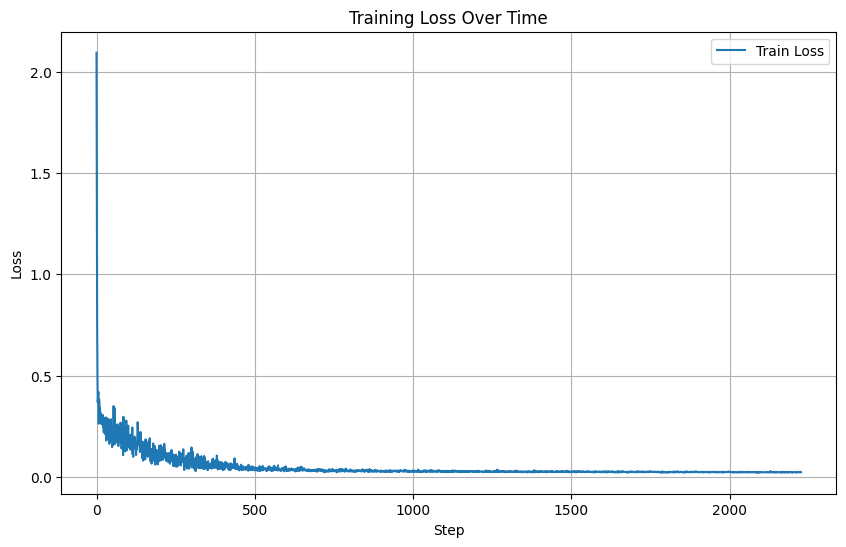

In [33]:
#train_loss 그래프 출력
import matplotlib.pyplot as plt

loss_values = []
for log in trainer.state.log_history:
    if "loss" in log:
        loss_values.append(log["loss"])

plt.figure(figsize=(10, 6))
plt.plot(loss_values, label="Train Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
model.save_pretrained("./model_directory")
tokenizer.save_pretrained("./model_directory")
config.save_pretrained("./model_directory")

In [36]:
model.push_to_hub("bkk21/triper_2411")
tokenizer.push_to_hub("bkk21/triper_2411")

adapter_model.safetensors: 100%|██████████| 9.18M/9.18M [00:00<00:00, 13.4MB/s]
tokenizer.json: 100%|██████████| 34.4M/34.4M [00:03<00:00, 8.82MB/s]


CommitInfo(commit_url='https://huggingface.co/bkk21/triper_2411/commit/3106df6cdb37dc77dfea0eb18ccb213921daab93', commit_message='Upload tokenizer', commit_description='', oid='3106df6cdb37dc77dfea0eb18ccb213921daab93', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bkk21/triper_2411', endpoint='https://huggingface.co', repo_type='model', repo_id='bkk21/triper_2411'), pr_revision=None, pr_num=None)

In [37]:
# PEFT 설정 파일을 Hub에 업로드 (추가 파일 업로드)
from huggingface_hub import HfApi

api = HfApi()
api.upload_file(
    path_or_fileobj="./model_directory/adapter_config.json",
    path_in_repo="adapter_config.json",
    repo_id="bkk21/triper_2411",
    repo_type="model"
)

CommitInfo(commit_url='https://huggingface.co/bkk21/triper_2411/commit/df1fae98e2f4786f57e12ff69b0832f02edb03f5', commit_message='Upload adapter_config.json with huggingface_hub', commit_description='', oid='df1fae98e2f4786f57e12ff69b0832f02edb03f5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bkk21/triper_2411', endpoint='https://huggingface.co', repo_type='model', repo_id='bkk21/triper_2411'), pr_revision=None, pr_num=None)

In [38]:
print("완료")

완료
